# calculates the SAM (Southern Annular Mode) as the first EOF (PC) on NCEP1 or NCEP2, either MSLP or Z 

In [1]:
%matplotlib inline

### os
import os
import sys

### datetimes
from datetime import datetime, timedelta

### scipy
import numpy as np
import pandas as pd
import xarray as xr
import dask
from dask.diagnostics import ProgressBar
from tqdm import tqdm

### plotting
from matplotlib import pyplot as plt
import matplotlib

### cartopy 
from cartopy import crs as ccrs
from cartopy.util import add_cyclic_point

In [2]:
from eofs.xarray import Eof # fails at retrieving the PCs, so we use PCA from scikit-learn instead 

In [3]:
from sklearn.decomposition import PCA

In [4]:
import requests
import urllib.request
import io

### config 

In [5]:
config = {}

config['NCEP1'] = {}
config['NCEP1']['MSLP'] = "https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis.derived/surface/slp.mon.mean.nc"
config['NCEP1']['Z'] = "https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis.derived/pressure/hgt.mon.mean.nc"
config['NCEP1']['start_year'] = 1948

config['NCEP2'] = {}
config['NCEP2']['MSLP'] = "https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis2.derived/surface/mslp.mon.mean.nc"
config['NCEP2']['Z'] = "https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis2.derived/pressure/hgt.mon.mean.nc"
config['NCEP2']['start_year'] = 1979

### parameters  

In [6]:
reanalysis = "NCEP1"
varname = "Z"
level = 1000 # if not set, and 'Z' is selected instead of 'MSLP', it will default to 1000 hPa
first_year = 1948 # can select the first year for analysis here, leave to `None` for all period available
domain = [0, 360, -90, -20] # domain is Southern Hemisphere
clim_period = [1981, 2010] # climatological `normal` 
lat_name = 'lat' # should always be `lat`
lon_name = 'lon' # should always be `lon`
std_per_month = False # whether the std is subtracted to each month individually 

### get the URL 

In [7]:
url = config[reanalysis][varname]

In [8]:
url

'https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis.derived/pressure/hgt.mon.mean.nc'

### reads straight from the FTP / HTTPS URL 

In [9]:
req = urllib.request.Request(url)

In [10]:
with urllib.request.urlopen(req) as resp:
    dset = xr.open_dataset(io.BytesIO(resp.read()))

In [11]:
dset

<xarray.Dataset>
Dimensions:  (level: 17, lat: 73, lon: 144, time: 905)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2023-05-01
Data variables:
    hgt      (time, level, lat, lon) float32 ...
Attributes:
    description:     Data from NCEP initialized reanalysis (4x/day).  These a...
    platform:       Model
    Conventions:    COARDS
    NCO:            20121012
    history:        Created by NOAA-CIRES Climate Diagnostics Center (SAC) fr...
    title:          monthly mean hgt from the NCEP Reanalysis
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

In [12]:
dset = dset.sortby('lat')

In [13]:
if 'time_bnds' in dset.variables: 
    dset = dset.drop('time_bnds')

### selections 

In [14]:
if first_year is not None: 
    if first_year >= config[reanalysis]['start_year']: 
        dset = dset.sel(time=slice(str(first_year), None))
    else: 
        print(f"The first year ({first_year}) needs to be >= to the start year in the {reanalysis} dataset: {config[reanalysis]['start_year']}")
    
if varname == 'Z': 
    if level is not None: 
        dset = dset.sel(level=level)
    else: 
        dset = dset.sel(level=1000.)

### selects the domain 

In [15]:
dset = dset.sel(lon=slice(*domain[:2]), lat=slice(*domain[2:]))

In [16]:
dset

<xarray.Dataset>
Dimensions:  (lat: 29, lon: 144, time: 905)
Coordinates:
    level    float32 1e+03
  * lat      (lat) float32 -90.0 -87.5 -85.0 -82.5 ... -27.5 -25.0 -22.5 -20.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2023-05-01
Data variables:
    hgt      (time, lat, lon) float32 ...
Attributes:
    description:     Data from NCEP initialized reanalysis (4x/day).  These a...
    platform:       Model
    Conventions:    COARDS
    NCO:            20121012
    history:        Created by NOAA-CIRES Climate Diagnostics Center (SAC) fr...
    title:          monthly mean hgt from the NCEP Reanalysis
    dataset_title:  NCEP-NCAR Reanalysis 1
    References:     http://www.psl.noaa.gov/data/gridded/data.ncep.reanalysis...

In [17]:
if len(list(dset.data_vars)) >= 1: 
    varid = list(dset.data_vars)[0]

In [18]:
varid

'hgt'

### adds a cyclic point 

In [19]:
data = dset[varid]

In [20]:
lon = dset.coords[lon_name]
lon_idx = data.dims.index('lon')

In [21]:
wrap_data, wrap_lon = add_cyclic_point(data.values, coord=lon, axis=lon_idx)

In [22]:
dset_wrap = {}
dset_wrap['time'] = dset['time']
dset_wrap[lon_name] = ((lon_name), wrap_lon)
dset_wrap[lat_name] = dset[lat_name]
dset_wrap[varid] = (('time',lat_name, lon_name), wrap_data)

In [23]:
dset_wrap = xr.Dataset(dset_wrap)

In [24]:
dset = dset_wrap

In [25]:
dset_wrap.close()

In [26]:
del(dset_wrap)

In [27]:
dset

<xarray.Dataset>
Dimensions:  (time: 905, lon: 145, lat: 29)
Coordinates:
    level    float32 1e+03
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2023-05-01
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 352.5 355.0 357.5 360.0
  * lat      (lat) float32 -90.0 -87.5 -85.0 -82.5 ... -27.5 -25.0 -22.5 -20.0
Data variables:
    hgt      (time, lat, lon) float32 -19.0 -19.0 -19.0 ... 167.0 164.8 162.9

### calculates the climatology 

In [28]:
climo = dset.sel(time=slice(*list(map(str, clim_period))))

In [29]:
climo = climo.groupby(climo.time.dt.month).mean('time')

### quick plot of the climatology

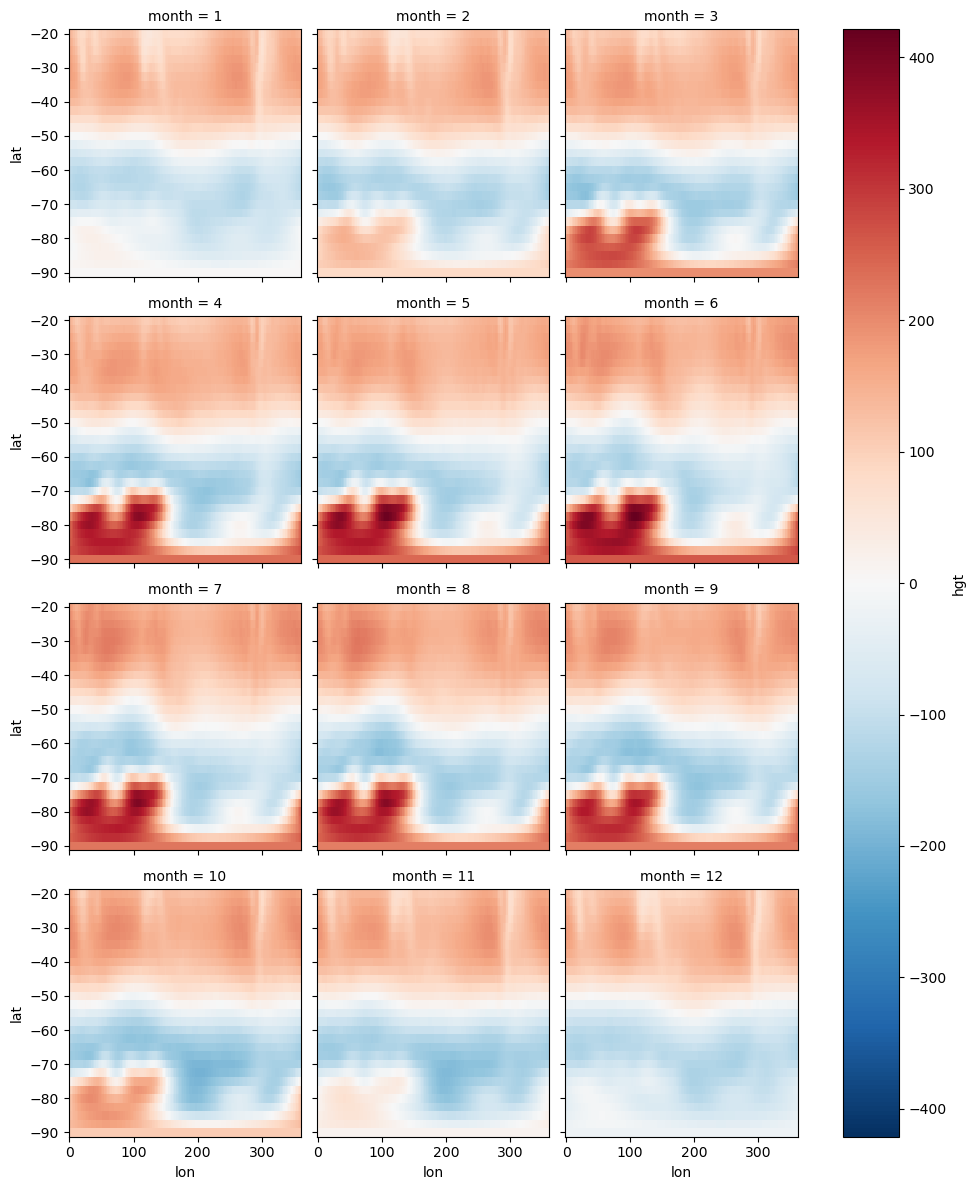

In [30]:
for varid in climo.data_vars: 
    climo[varid].plot(col='month', col_wrap=3) 

### calculates the anomalies 

In [31]:
dset_anoms = dset.groupby(dset.time.dt.month) - climo

### standardize per month ?

In [32]:
if std_per_month: 
    
    print("\nwe standardize per month\n") 
    
    def standardize(x): 
        z = (x - x.sel(time=slice(f'{str(clim_period[0])}-01-01',f'{str(clim_period[-1])}-12-01')).mean('time')) / x.std('time')
        return z
                                                                
    dset_anoms = dset.groupby(dset_anoms.time.dt.month).apply(standardize)                                

### then standardize, using average and standard deviation calculated over the climatological period 

In [33]:
ave = dset_anoms.sel(time=slice(f'{str(clim_period[0])}-01-01',f'{str(clim_period[-1])}-12-01')).mean('time')

In [34]:
std = dset_anoms.sel(time=slice(f'{str(clim_period[0])}-01-01',f'{str(clim_period[-1])}-12-01')).std('time')

In [35]:
dset_anoms = (dset_anoms - ave) / std

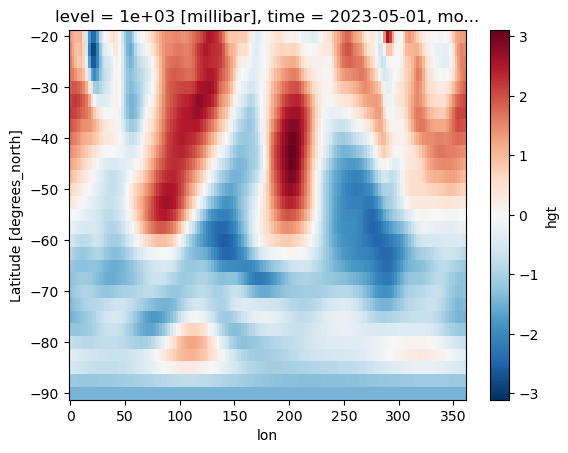

In [36]:
dset_anoms.isel(time=-1)[varid].plot()

### weights by the square root of the cosine of the latitude 

In [37]:
coslat = np.cos(np.deg2rad(dset_anoms.lat.data))

wgts = np.sqrt(coslat)[..., np.newaxis]

/tmp/ipykernel_31945/754575767.py:3: RuntimeWarning: invalid value encountered in sqrt
  wgts = np.sqrt(coslat)[..., np.newaxis]


In [38]:
wgts[0] = np.array([1e-9])

### adds the weights to the dataset 

In [39]:
dset_anoms['weights'] = (('lat'), wgts.squeeze())

### prepare for EOF using sklearn 

In [40]:
dset_anoms[f'{varid}_weighted'] = dset_anoms[varid] * dset_anoms['weights']  

### select the data now and stack 

In [41]:
X = dset_anoms[[f'{varid}_weighted']]

In [42]:
X = X.stack(z=(lat_name, lon_name))

### we will retrieve only the first EOF / PC 

In [43]:
pca = PCA(n_components=1)

In [44]:
pca.fit(X[f'{varid}_weighted'].data)

PCA(n_components=1)

In [45]:
variance_fractions = pca.explained_variance_ratio_

In [46]:
variance_fractions

array([0.21495001], dtype=float32)

### retrieve the PC(s)

In [47]:
PCs = pca.transform(X[f'{varid}_weighted'].data)

### retrieve the EOF

In [48]:
EOFs = pca.components_

In [49]:
EOFs.shape

(1, 4205)

In [50]:
X['EOF'] = (('z'), EOFs.squeeze())

In [51]:
X['PC'] = (('time'), PCs.squeeze())

In [52]:
X = X.unstack()

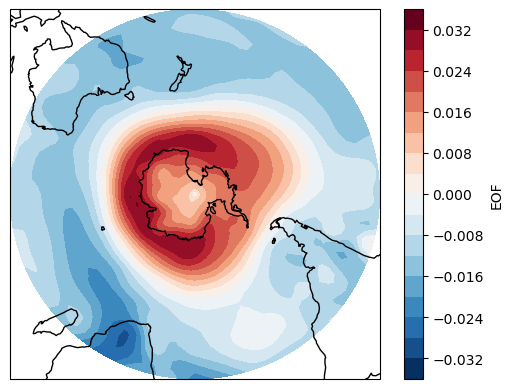

In [53]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.SouthPolarStereo(central_longitude=180)))
X['EOF'].plot.contourf(ax=ax, levels=20, transform=ccrs.PlateCarree())
ax.coastlines()

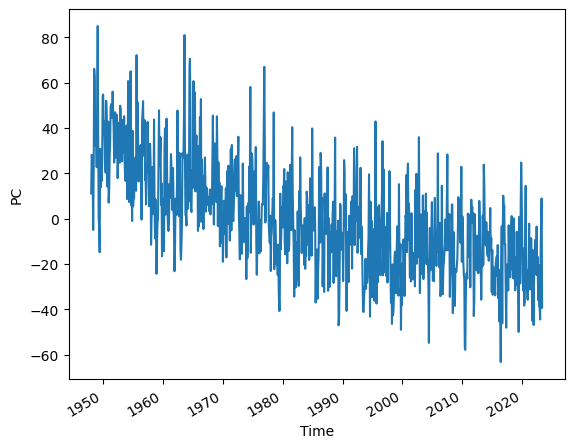

In [54]:
X['PC'].plot()

## we need to multiply the PC by -1 

In [55]:
X['PC'] = X['PC'] * -1

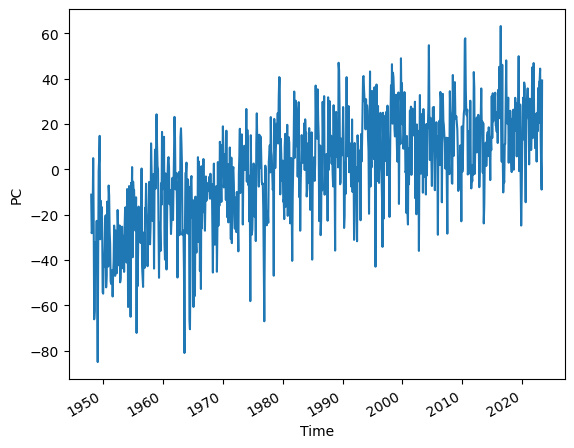

In [56]:
X['PC'].plot()

### then we standardize (WRT average and standard deviation calculated over the climatological period) 

In [57]:
ave = X['PC'].sel(time=slice(f'{str(clim_period[0])}-01-01',f'{str(clim_period[-1])}-12-01')).mean('time')

In [58]:
std = X['PC'].sel(time=slice(f'{str(clim_period[0])}-01-01',f'{str(clim_period[-1])}-12-01')).std('time')

In [66]:
PC = (X['PC'] - ave) / std

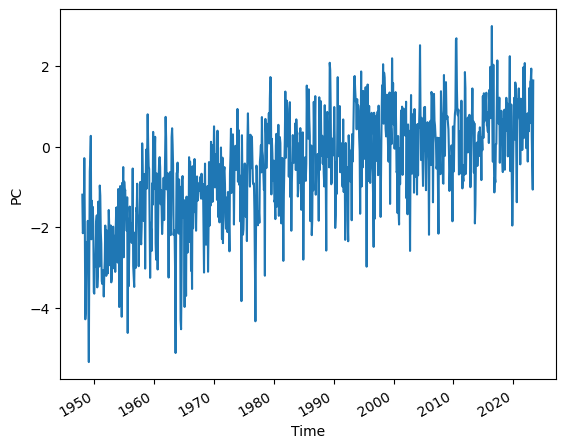

In [67]:
PC.plot()

In [69]:
PC_df = PC.to_pandas()

In [71]:
PC_df = PC_df.to_frame(name='SAM')

In [72]:
PC_df

,SAM
time,
1948-01-01,-1.193634
1948-02-01,-2.151182
1948-03-01,-2.085021
1948-04-01,-1.631576
1948-05-01,-0.286013
...,...
2023-01-01,1.938399
2023-02-01,0.240437
2023-03-01,-0.462695


### saves to disk 

In [74]:
PC_df.to_csv('/media/nicolasf/END19101/data/PICT/datasets/Indices/SAM_index_1948_2021_1981_2010_Clim.csv')